# Lab. 4: (Reduced) Variable Neighborhood Search

## Introduction

#### <u>The goal of this laboratory is to compare the behavior of VNS and RVNS on the knapsack 0/1 problem.</u>

You'll have to implement two methods:

- shake(x, k). Try different implementation of the shake method:
  - flip k bits taken randomly in the binary vector x
  - flip max(1, k-1) bits in the binary vector x
  - flip at least k bits in the binary vector x
  - ...
- local_search(f, x)
  - different implementations of VNS use as local search either FirstImprovement or BestImprovement algorithms

---

Getting started: The following cells contain the implementation of the methods that we will use throughout this lab, together with utilities.

**The Knapsack 0/1 problem** is a combinatorial problem that works as follows.

We have a bag with limited capacity L, and we have a set of items  $I=\{i_1,...,i_N\}$  Each  $i_j$  has a given volume $w_{ij}$ and a value $v_{ij}$. The goal of the optimization problem is to fill the bag with a combination of items $S$ such that the combination maximizes the total value contained by the bag while complaining with the constraint on the capacity.

In this version of the knapsack problem we can either discard or carry (at most 1) item. Thus, the search space is $\{0,1\}^{|I|}$ .

Since this is a maximization problem, we can turn it into a minimization problem by returning the opposite of the value. If a solution is not feasible (i.e., exceeds the maximum volume) the function will return a score of 0 (like an empty bag).


Assume
$$ N = \text{number of items} $$
$$ X = \{x_1, x_2, \dots, x_N\} = \text{set of items} $$
$$ v_i = \text{value of item } x_i $$
$$ w_i = \text{weight of item } x_i $$
$$ W = \text{maximum weight the knapsack can hold} $$


Then the 0/1 knapsack problem can be formulated as follows:

\begin{equation*}
  \begin{array}{lr@{}c@{}r@{}l}
    \text{maximize }   &S = \sum_{x_i \in X} v_i x_i \\
    \text{subject to } & \sum_{x_i \in X} w_i x_i \leq W \\
                       & x_i \in \{0, 1\} \forall x_i \in X \\
  \end{array}
\end{equation*}

In [47]:
from matplotlib import pyplot as plt
class Knapsack_0_1:

    def __init__(self):
        self._items = [
            {'name': 'apple', 'value': 1, 'volume': 2},
            {'name': 'pear', 'value': 2, 'volume': 2},
            {'name': 'banana', 'value': 2, 'volume': 2},
            {'name': 'watermelon', 'value': 5, 'volume': 10},
            {'name': 'orange', 'value': 3, 'volume': 2},
            {'name': 'avocado', 'value': 3, 'volume': 2},
            {'name': 'blueberry', 'value': 3, 'volume': 1},
            {'name': 'coconut', 'value': 4, 'volume': 3},
            {'name': 'cherry', 'value': 2, 'volume': 1},
            {'name': 'apricot', 'value': 1, 'volume': 1},
        ]
        self._BAG_CAPACITY = 10
        self.history = []
        self.values = []

    def _get_value(self, solution):
        cur_cap = self._BAG_CAPACITY
        cur_val = 0
        for i, v in enumerate(solution):
            if v == 1:
                cur_val += self._items[i]['value']
                cur_cap -= self._items[i]['volume']
            if cur_cap < 0:
                return 0
        return -cur_val

    def __call__(self, solution):
        value = self._get_value(solution)
        self.history.append(solution)
        self.values.append(value)
        return value

    def trend(self):
        plt.figure()
        plt.plot(self.values)
        plt.show()

In [86]:
import numpy as np
from matplotlib import pyplot as plt
from itertools import combinations
import copy
import random


def shake(x, k):
    """
    Implements the shaking step for the VNS algorithm. It generates a random x' contained in the neighborhood k of x

    - x: starting point from which the neighborhood is created
    - k: the neighborhood distance (1 for the nearest, 2 for a slightly bigger neighborhood, and so on)

    Returns:
    - The random x' sampled from the neighborhood
    """
    #print(x,k)
    # To be implemented
    # Must: use copy.deepcopy(x) to work on copies of x
    xp = copy.deepcopy(x)
    for i in range(k):
        index = random.randint(0, len(x) - 1)
        if xp[index] == 0:
            xp[index] = 1
        else:
            xp[index] = 0
        
    return xp


def move_or_not(f, x, xs, k):
    if f(xs) < f(x):
        x = xs
        k = 1
    else:
        k += 1
    return x, k

def local_search(f, x, method):
    """
    Implements the local search step for the VNS algorithm. It search for a better x' in the neighborhood

    - f: function to minimize
    - x: starting point of the local search

    Returns:
    - The improved x'
    """
    # To be implemented
    # Must: use copy.deepcopy(x) to work on copies of x
    xp = copy.deepcopy(x)
    if method == 'BestImprovment':
        for i in range(len(xp)):
            if xp[i] == 1:
                xp[i] = 0
            else:
                xp[i] = 1
            if f(xp) > f(x):
                x = xp
    elif method == 'FirstImprovment':
        for i in range(len(xp)):
            if xp[i] == 1:
                xp[i] = 0
            else:
                xp[i] = 1
            if f(xp) > f(x):
                x = xp
                break
    return x


def vns(f, x0, kmax, method):
    """
    Seeks for the minimum of the function by means of the Variable Neighborhood
    Search algorithm.

    :f: the function to optimize
    :x0: the initial point
    :kmax: the max number of iterations for each neighborhood
    """
    n = 0
    x = np.array(x0, float)
    best = x
    bestval = f(x)
    k = 0
    #method = 'BestImprovment'
    while k < kmax:
        xp = shake(x, k)
        xs = local_search(f, xp, method)
        #xs = local_search(f, xp)
        x, k = move_or_not(f, x, xs, k)

        # Store the best
        curval = f(x)
        if curval < bestval:
            bestval = curval
            best = x
    return best


def rvns(f, x0, kmax):
    """
    Seeks for the minimum of the function by means of the Reduced Variable
    Neighborhood Search algorithm.

    :f: the function to optimize
    :x0: the initial point
    :kmax: the max number of iterations for each neighborhood
    """
    n = 0
    x = np.array(x0, float)
    best = x
    bestval = f(x)

    k = 0
    while k < kmax:
        print(x)
        xp = shake(x, k)
        x, k = move_or_not(f, x, xp, k)
    return best

# Variable Neighborhood Search
---
## Questions:
- how does the starting point influence the search process?
- how does the kmax parameter affect the quality of the result?
- how does the generation of the neighborhood (for the shaking) affect:
    - quality of the search?
    - speed of the search?

In [51]:
dio = Knapsack_0_1()
prova = [0] * len(dio._items)
prova[-3] = 1
prova[3] = 1
print(prova)
dio(prova)

[0, 0, 0, 1, 0, 0, 0, 1, 0, 0]


0

In [12]:
[0] * len(dio._items)

[0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

BestImprovment



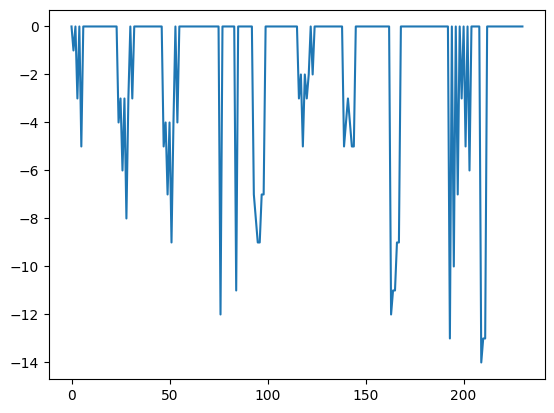

FirstImprovment



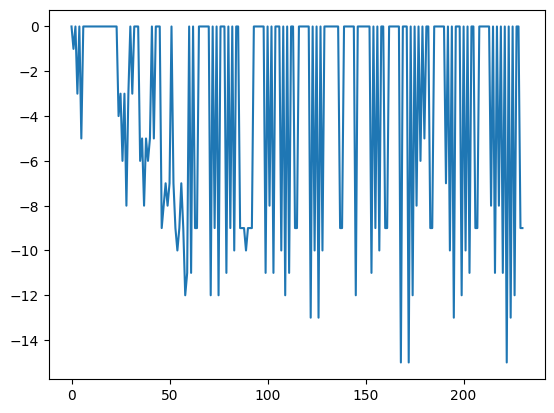

In [87]:
func_0 = Knapsack_0_1()
func_1 = Knapsack_0_1()

methods = ["BestImprovment","FirstImprovment"]
for i in methods:
    if i == "FirstImprovment":
        print(f"{i}\n")
        vns(func_0, [0] * len(func._items), 10, i)
        func_0.trend()
    else:
        print(f"{i}\n")
        vns(func_1, [0] * len(func._items), 10, i)
        func_1.trend()

# Reduced Variable Neighborhood Search
---
## Questions:
- how does the starting point influence the search process?
- how does the kmax parameter affect the quality of the result?
- how does the generation of the neighborhood affect:
    - quality of the search?
    - velocity of the search?
- how does RVNS compare to VNS?

In [ ]:
func = Knapsack_0_1()
rvns(func, [0] * len(func._items), 10)
func.trend()